In [1]:
from couplevae import *
import scanpy as sc
# 环境配置与包导入
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
# mpl.use('Agg')  # 如果你在 Notebook 中想显示图，可以注释掉这一行
from scipy.sparse import issparse
from scipy import sparse
from adjustText import adjust_text

from couplevae import *  # 确保你已经正确安装了 couplevae


In [2]:
# 路径与参数设置
train_path = "data\\train\\train_pbmc.h5ad"
valid_path = "data\\valid\\valid_pbmc.h5ad"
test_path = "data\\test\\test_pbmc.h5ad"

data_name = "pbmc"
cell_type = "CD4T"
condition_key = "condition"
cell_type_key = "cell_type"
pert_key = "stimulated"
ctrl_key = "control"
device = "cuda"  # 如果没有 GPU 可以设置为 "cpu"

In [3]:
# 加载 AnnData 数据
train = sc.read(train_path)
valid = sc.read(valid_path)
test = sc.read(test_path)


In [4]:
trainloader = load_h5ad_to_dataloader(train, condition_key, cell_type_key, 
                                       cell_type, ctrl_key, pert_key, device)
validloader = load_h5ad_to_dataloader(valid, condition_key, cell_type_key, 
                                       cell_type, ctrl_key, pert_key, device)

test_adata_c = test[(test.obs[condition_key]==ctrl_key)&(test.obs[cell_type_key]==cell_type)]  
test_adata_p = test[(test.obs[condition_key]==pert_key)&(test.obs[cell_type_key]==cell_type)]


In [5]:
network = VAE(x_dim=train.X.shape[1],
              z_dim=200,
              alpha=0.00005,
              beta=0.05,
              dropout_rate=0.1,
              learning_rate=0.0001)

trainer = Trainer(model=network, learning_rate=0.0001, n_epochs=100, patience=20, batch_size=128)

# 训练模型
trainer.train(train_loader=trainloader, valid_loader=validloader)


d:\anaconda\envs\couplevae_env\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
d:\anaconda\envs\couplevae_env\Lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Epoch 1, Train Loss: 247.0399, Validation Loss: 210.1806
Epoch 2, Train Loss: 215.0918, Validation Loss: 204.6725
Epoch 3, Train Loss: 211.2768, Validation Loss: 201.7065
Epoch 4, Train Loss: 208.4668, Validation Loss: 199.0655
Epoch 5, Train Loss: 205.6891, Validation Loss: 196.7726
Epoch 6, Train Loss: 203.3752, Validation Loss: 195.1639
Epoch 7, Train Loss: 201.5351, Validation Loss: 193.3958
Epoch 8, Train Loss: 200.1312, Validation Loss: 192.3582
Epoch 9, Train Loss: 198.9984, Validation Loss: 191.2503
Epoch 10, Train Loss: 197.9843, Validation Loss: 190.7000
Epoch 11, Train Loss: 197.0215, Validation Loss: 190.6072
Epoch 12, Train Loss: 196.1705, Validation Loss: 190.6377
Epoch 13, Train Loss: 195.4773, Validation Loss: 188.6677
Epoch 14, Train Loss: 194.7641, Validation Loss: 187.8342
Epoch 15, Train Loss: 193.9127, Validation Loss: 186.7540
Epoch 16, Train Loss: 192.9352, Validation Loss: 186.4993
Epoch 17, Train Loss: 192.0160, Validation Loss: 185.4891
Epoch 18, Train Loss: 1

In [6]:
pred = network.predict(test_adata_c, test_adata_p)

# 包装为 AnnData
pred_adata = anndata.AnnData(pred, 
                             obs={condition_key: [f"{cell_type}_pred_pert"] * len(pred),
                                  cell_type_key: [cell_type] * len(pred)},
                             var={"var_names": test_adata_c.var_names})

if sparse.issparse(test_adata_c.X):
    test_adata_c.X = test_adata_c.X.toarray() 
ctrl_adata = anndata.AnnData(test_adata_c.X,
                             obs={condition_key: [f"{cell_type}_ctrl"] * len(test_adata_c),
                                  cell_type_key: [cell_type] * len(test_adata_c)},
                             var={"var_names": test_adata_c.var_names})

if sparse.issparse(test_adata_p.X):
    test_adata_p.X = test_adata_p.X.toarray() 
real_stim_adata = anndata.AnnData(test_adata_p.X,
                                  obs={condition_key: [f"{cell_type}_real_pert"] * len(test_adata_p),
                                       cell_type_key: [cell_type] * len(test_adata_p)},
                                  var={"var_names": test_adata_p.var_names})

# 合并结果保存
all_data = ctrl_adata.concatenate(pred_adata, real_stim_adata)
all_data.write_h5ad(f"./coupleVAE{data_name}_{cell_type}.h5ad")


d:\anaconda\envs\couplevae_env\Lib\site-packages\anndata\_core\anndata.py:602: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
  warnings.warn(msg, FutureWarning, stacklevel=1)
C:\Users\jerry-ai\AppData\Local\Temp\ipykernel_34492\184023674.py:10: ImplicitModificationWarning: Modifying `X` on a view results in data being overridden
  test_adata_c.X = test_adata_c.X.toarray()
d:\anaconda\envs\couplevae_env\Lib\site-packages\anndata\_core\anndata.py:602: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
  wa

In [7]:
def plot_gene_correlation(data, cond_col, axes_map, label_map, file_path='./output_plot.pdf', 
                          genes_of_interest=None, top_genes=None, show_plot=False, include_legend=True, 
                          plot_title='', x_offset=0.3, y_offset=0.8, text_size=14):
    if genes_of_interest is None:
        genes_of_interest = []
    if top_genes is None:
        top_genes = []

    if issparse(data.X):
        data.X = data.X.toarray()

    group_y = data[data.obs[cond_col] == axes_map['y'], :]
    group_x = data[data.obs[cond_col] == axes_map['x'], :]

    if len(top_genes) > 0:
        subset_data_x = group_x[:, top_genes].X
        subset_data_y = group_y[:, top_genes].X
        avg_x_genes = np.mean(subset_data_x, axis=0)
        avg_y_genes = np.mean(subset_data_y, axis=0)
        r_squared_top = np.corrcoef(avg_x_genes, avg_y_genes)[0, 1] ** 2
        print(f'R-squared for top genes: {r_squared_top:.2f}')

    avg_x = np.mean(group_x.X, axis=0)
    avg_y = np.mean(group_y.X, axis=0)
    r_squared_all = np.corrcoef(avg_x, avg_y)[0, 1] ** 2
    print(f'R-squared for all genes: {r_squared_all:.2f}')

    df = pd.DataFrame({label_map['x']: avg_x, label_map['y']: avg_y})
    plt.figure()
    ax = sns.regplot(x=label_map['x'], y=label_map['y'], data=df, scatter_kws={'s': 10}, line_kws={'color': 'green'})
    plt.xlabel(label_map['x'], fontsize=text_size)
    plt.ylabel(label_map['y'], fontsize=text_size)

    if plot_title:
        plt.title(plot_title, fontsize=text_size)

    if len(genes_of_interest) > 0:
        texts = []
        for gene in genes_of_interest:
            gene_idx = np.where(data.var_names == gene)[0][0]
            x_pos = avg_x[gene_idx]
            y_pos = avg_y[gene_idx]
            texts.append(plt.text(x_pos, y_pos, gene, fontsize=10, color='black'))
            plt.scatter(x_pos, y_pos, color='red', s=40)
        adjust_text(texts, arrowprops=dict(arrowstyle="->", color='grey', lw=0.5))

    plt.text(max(avg_x) - max(avg_x) * x_offset, max(avg_y) - y_offset * max(avg_y),
             r'$\mathrm{R^2_{\mathrm{\mathsf{all\ genes}}}}$='+ f"{r_squared_all:.2f}", fontsize=text_size)

    if len(top_genes) > 0:
        plt.text(max(avg_x) - max(avg_x) * x_offset, max(avg_y) - (y_offset + 0.15) * max(avg_y),
                r'$\mathrm{R^2_{\mathrm{\mathsf{top\ 100\ DEGs}}}}$='+ f"{r_squared_top:.2f}", fontsize=text_size)

    if include_legend:
        plt.legend(loc='best')

    plt.savefig(file_path, bbox_inches='tight', dpi=300)
    if show_plot:
        plt.show()
    plt.close()


In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text
from scipy.sparse import issparse

def plot_gene_correlation(data, cond_col, axes_map, label_map, file_path='./output_plot.pdf', 
                          genes_of_interest=None, top_genes=None, show_plot=False, include_legend=True, 
                          plot_title='', x_offset=0.3, y_offset=0.8, text_size=14):
    if genes_of_interest is None:
        genes_of_interest = []
    if top_genes is None:
        top_genes = []

    if issparse(data.X):
        data.X = data.X.toarray()

    group_y = data[data.obs[cond_col] == axes_map['y'], :]
    group_x = data[data.obs[cond_col] == axes_map['x'], :]

    # top genes R^2
    r_squared_top = None
    if len(top_genes) > 0:
        subset_data_x = group_x[:, top_genes].X
        subset_data_y = group_y[:, top_genes].X
        avg_x_genes = np.mean(subset_data_x, axis=0)
        avg_y_genes = np.mean(subset_data_y, axis=0)
        r_squared_top = np.corrcoef(avg_x_genes, avg_y_genes)[0, 1] ** 2
        print(f'R-squared for top genes: {r_squared_top:.2f}')

    avg_x = np.mean(group_x.X, axis=0)
    avg_y = np.mean(group_y.X, axis=0)
    r_squared_all = np.corrcoef(avg_x, avg_y)[0, 1] ** 2
    print(f'R-squared for all genes: {r_squared_all:.2f}')

    df = pd.DataFrame({label_map['x']: avg_x, label_map['y']: avg_y})

    # 美化设置
    sns.set_style("white")
    fig, ax = plt.subplots(figsize=(4.5, 4))  # 设置为正方形
    # sns.despine()

    # 绘制拟合线 + 散点图
    sns.regplot(x=label_map['x'], y=label_map['y'], data=df,
                scatter_kws={'s': 50, 'alpha': 0.5}, 
                line_kws={'color': 'green'}, ax=ax)

    ax.set_xlabel(label_map['x'], fontsize=text_size)
    ax.set_ylabel(label_map['y'], fontsize=text_size)
    ax.grid(False)  # 去掉背景网格

    if plot_title:
        ax.set_title(plot_title, fontsize=text_size)

    # 标注关注基因
    texts = []
    for gene in genes_of_interest[:5]:  # 只显示前10个
        if gene in data.var_names:
            gene_idx = np.where(data.var_names == gene)[0][0]
            x_pos = avg_x[gene_idx]
            y_pos = avg_y[gene_idx]
            texts.append(ax.text(x_pos, y_pos, gene, fontsize=10, color='black'))
            ax.scatter(x_pos, y_pos, color='red', s=60, zorder=3)

    if texts:
        adjust_text(texts, arrowprops=dict(arrowstyle="->", color='gray', lw=0.6))

    # 添加 R² 注释
    ax.text(max(avg_x) - max(avg_x) * x_offset, max(avg_y) - y_offset * max(avg_y),
            r'$R^2_{\mathrm{all\ genes}}$' + f" = {r_squared_all:.2f}", fontsize=text_size)

    if r_squared_top is not None:
        ax.text(max(avg_x) - max(avg_x) * x_offset, 
                max(avg_y) - (y_offset + 0.15) * max(avg_y),
                r'$R^2_{\mathrm{top\ 100\ DEGs}}$' + f" = {r_squared_top:.2f}", fontsize=text_size)

    if include_legend:
        ax.legend(loc='best')

    plt.tight_layout()
    if file_path:
        plt.savefig(file_path, bbox_inches='tight', dpi=300)
    if show_plot:
        plt.show()
    plt.close()


In [9]:
def plot_gene_correlation(data, cond_col, axes_map, label_map, file_path='./output_plot.pdf', 
                          genes_of_interest=None, top_genes=None, show_plot=False, include_legend=True, 
                          plot_title='', x_offset=0.05, y_offset=0.95, text_size=14, reg_type='mean'):
    import numpy as np
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    from adjustText import adjust_text
    from scipy.sparse import issparse

    sns.set(style="white", context="notebook")  # 或 'talk', 'paper'
    plt.rcParams['axes.linewidth'] = 1.2  # 坐标轴线宽
    plt.rcParams['xtick.major.width'] = 1.2
    plt.rcParams['ytick.major.width'] = 1.2

    if genes_of_interest is None:
        genes_of_interest = []
    if top_genes is None:
        top_genes = []

    if issparse(data.X):
        data.X = data.X.toarray()

    group_y = data[data.obs[cond_col] == axes_map['y'], :]
    group_x = data[data.obs[cond_col] == axes_map['x'], :]

    # 选择均值或方差
    if reg_type == 'mean':
        avg_func = np.mean
    elif reg_type == 'var':
        avg_func = np.var
    else:
        raise ValueError("reg_type must be 'mean' or 'var'")

    r_squared_top = None
    if len(top_genes) > 0:
        subset_data_x = group_x[:, top_genes].X
        subset_data_y = group_y[:, top_genes].X
        avg_x_genes = avg_func(subset_data_x, axis=0)
        avg_y_genes = avg_func(subset_data_y, axis=0)
        r_squared_top = np.corrcoef(avg_x_genes, avg_y_genes)[0, 1] ** 2
        print(f'R-squared for top genes: {r_squared_top:.2f}')

    avg_x = avg_func(group_x.X, axis=0)
    avg_y = avg_func(group_y.X, axis=0)
    r_squared_all = np.corrcoef(avg_x, avg_y)[0, 1] ** 2
    print(f'R-squared for all genes: {r_squared_all:.2f}')

    df = pd.DataFrame({label_map['x']: avg_x, label_map['y']: avg_y})

    sns.set_style("white")
    fig, ax = plt.subplots(figsize=(4, 4))

    sns.regplot(x=label_map['x'], y=label_map['y'], data=df,
                scatter_kws={'s': 60, 'alpha': 0.5},
                line_kws={'color': 'green'}, ax=ax)

    ax.set_xlabel(label_map['x'], fontsize=text_size)
    ax.set_ylabel(label_map['y'], fontsize=text_size)
    ax.grid(False)

    if plot_title:
        ax.set_title(plot_title, fontsize=text_size)

    # 标注基因
    texts = []
    for gene in genes_of_interest[:10]:
        if gene in data.var_names:
            gene_idx = np.where(data.var_names == gene)[0][0]
            x_pos = avg_x[gene_idx]
            y_pos = avg_y[gene_idx]
            texts.append(ax.text(x_pos, y_pos, gene, fontsize=10, color='black'))
            ax.scatter(x_pos, y_pos, color='red', s=60, zorder=3)
    if texts:
        adjust_text(texts, arrowprops=dict(arrowstyle="->", color='gray', lw=0.6))

    # 使用 ax.transAxes 保证一致位置
    ax.text(x_offset, y_offset,
            r'$R^2_{\mathrm{all\ genes}}$' + f" = {r_squared_all:.2f}",
            transform=ax.transAxes, fontsize=text_size)

    if r_squared_top is not None:
        ax.text(x_offset, y_offset - 0.1,
                r'$R^2_{\mathrm{top\ 100\ DEGs}}$' + f" = {r_squared_top:.2f}",
                transform=ax.transAxes, fontsize=text_size)

    if include_legend:
        ax.legend(loc='best')

    plt.tight_layout()
    if file_path:
        plt.savefig(file_path, bbox_inches='tight', dpi=300)
    if show_plot:
        plt.show()
    plt.close()

R-squared for top genes: 1.00
R-squared for all genes: 0.99


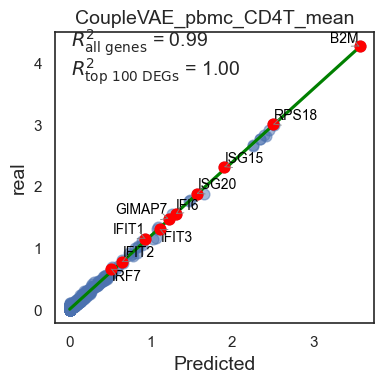

R-squared for top genes: 0.90
R-squared for all genes: 0.79


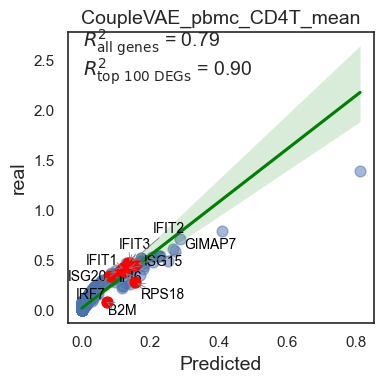

In [10]:
import scanpy as sc
result = sc.read(f"./coupleVAE{data_name}_{cell_type}.h5ad")

sc.tl.rank_genes_groups(result, groupby="condition", n_genes=100, method="wilcoxon")

diff_genes_covid = result.uns["rank_genes_groups"]["names"][f"{cell_type}_real_pert"]

conditions = {
    "ctrl": f"{cell_type}_ctrl",
    "pred_stim": f"{cell_type}_pred_pert",
    "real_stim": f"{cell_type}_real_pert"
}

plot_gene_correlation(data=result,
                      cond_col="condition",
                      axes_map={"x": conditions["pred_stim"], "y": conditions["real_stim"]},
                      label_map={"x": "Predicted", "y": "real"},
                      genes_of_interest=diff_genes_covid[:10],
                      top_genes=diff_genes_covid,
                      reg_type='mean',  # 或 'var'
                      plot_title="CoupleVAE_pbmc_CD4T_mean",
                      show_plot=True,
                    #   fontsize=12,
                      include_legend=False)
plot_gene_correlation(data=result,
                      cond_col="condition",
                      axes_map={"x": conditions["pred_stim"], "y": conditions["real_stim"]},
                      label_map={"x": "Predicted", "y": "real"},
                      genes_of_interest=diff_genes_covid[:10],
                      top_genes=diff_genes_covid,
                      reg_type='var',  # 或 'var'
                      plot_title="CoupleVAE_pbmc_CD4T_mean",
                      show_plot=True,
                    #   fontsize=12,
                      include_legend=False)
# plot_gene_correlation(result, 
#                       cond_col="condition",
#                       axes_map={"x": conditions["pred_stim"], "y": conditions["real_stim"]},
#                       genes_of_interest=diff_genes_covid[:10],  # 显示前10个
#                       top_genes=diff_genes_covid,
#                       include_legend=False,
#                       label_map={"x": "pred", "y": "real"},
#                       plot_title=f"CoupleVAE_{data_name}_{cell_type}",
#                       show_plot=True)

# plot_gene_correlation(result, 
#                       cond_col="condition",
#                       axes_map={"x": conditions["pred_stim"], "y": conditions["real_stim"]},
#                       genes_of_interest=diff_genes_covid[:5],
#                       top_genes=diff_genes_covid,
#                       include_legend=False,
#                       label_map={"x": "pred", "y": "real"},
#                       plot_title=f"CoupleVAE_{cell_type}",
#                     #   file_path=f"./CoupleVAE_{cell_type}.pdf",
#                       # file_path=None,
#                       show_plot=True)


d:\anaconda\envs\couplevae_env\Lib\site-packages\scanpy\neighbors\__init__.py:586: UserWarning: You’re trying to run this on 6998 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  X = _choose_representation(self._adata, use_rep=use_rep, n_pcs=n_pcs)


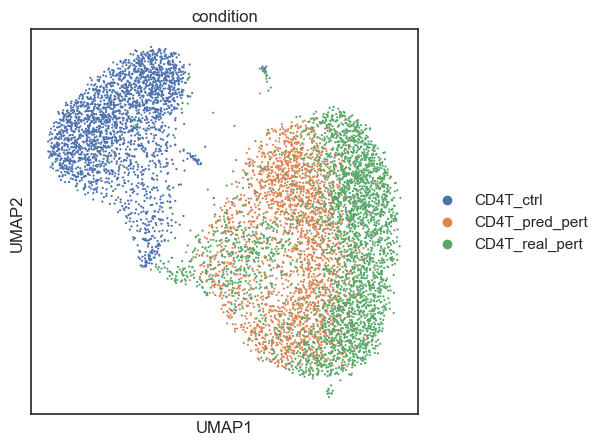

In [11]:
sc.pp.neighbors(result,n_neighbors=50)
sc.tl.umap(result)


import scanpy as sc
import matplotlib.pyplot as plt

# 先画图，返回 matplotlib 的 Axes 对象
ax = sc.pl.umap(result,
                color='condition',
                frameon=True,
                size=10,
                show=False,  # 先不显示
                return_fig=True)  # 返回 matplotlib Figure

# 设置标题、尺寸
fig = plt.gcf()  # 获取当前图像
fig.set_size_inches(5, 5)  # 设置尺寸
# ax[0].set_title("UMAP of CD4T under Different Conditions", fontsize=14)

plt.show()


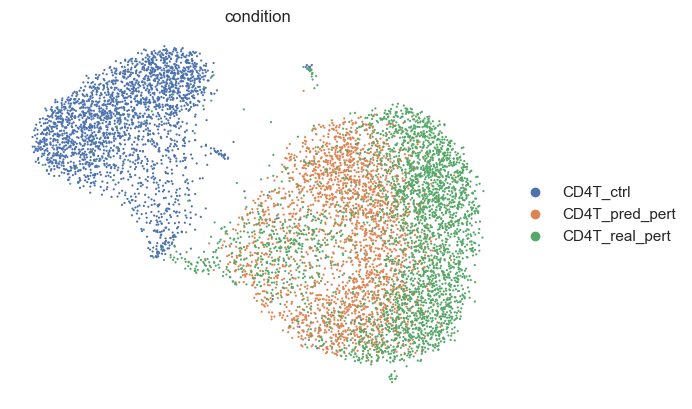

In [12]:


sc.pl.umap(result,
           color=['condition'],
           frameon=False,
           wspace=0.5,
           size=10)


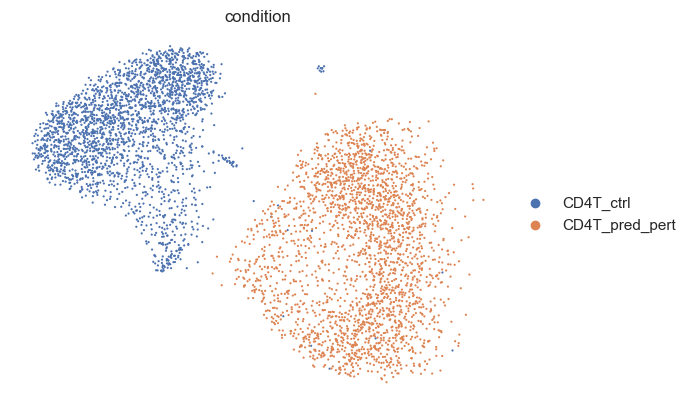

In [13]:
subset_result = result[result.obs['condition'].isin(['CD4T_ctrl', 'CD4T_pred_pert'])]

sc.pl.umap(subset_result,
           color=['condition'],
           frameon=False,
           wspace=0.1,
           size=10)


In [14]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

sc.pl.umap(adata,
           color=['condition'],
           frameon=False,
           wspace=0.3)

NameError: name 'adata' is not defined

In [15]:
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

def plot_violin_compare_pert(adata,
                              genes,
                              condition_key='condition',
                              ctrl_label='CD4T_ctrl',
                              real_label='CD4T_real_pert',
                              pred_label='CD4T_pred_pert',
                              cell_type='CD4T',
                              save_path=None,
                              show=True,
                              return_figs=False,
                              figsize=(4, 3),
                              fontsize=12):
    """
    绘制小提琴图，对比 ctrl、真实扰动和预测扰动的表达分布，并显示散点。
    """
    # 筛选三类条件
    valid_labels = [ctrl_label, pred_label, real_label]
    subset = adata[adata.obs[condition_key].isin(valid_labels)]

    figs = []
    for gene in genes:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_axes([0.2, 0.2, 0.7, 0.7])
        
        sc.pl.violin(subset,
                     keys=gene,
                     groupby=condition_key,
                     ax=ax,
                     stripplot=True,    # 显示散点
                     jitter=True,       # 增加抖动
                     show=False)
        
        ax.set_title(f'Expression of {gene} in {cell_type}', fontsize=fontsize)
        ax.set_ylabel("Expression", fontsize=fontsize)
        ax.set_xlabel("Condition", fontsize=fontsize)
        ax.tick_params(labelsize=fontsize - 2)
        figs.append(fig)

    # 保存 PDF
    if save_path:
        with PdfPages(save_path) as pdf:
            for fig in figs:
                pdf.savefig(fig, bbox_inches='tight', dpi=300)
                plt.close(fig)

    # 显示
    if show:
        for fig in figs:
            fig.show()

    # 返回对象
    if return_figs:
        return figs


C:\Users\jerry-ai\AppData\Local\Temp\ipykernel_34492\1926516541.py:53: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


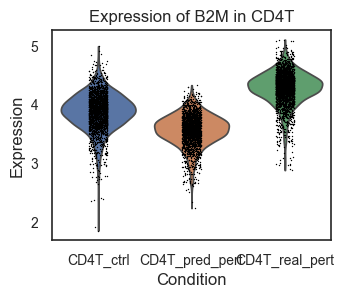

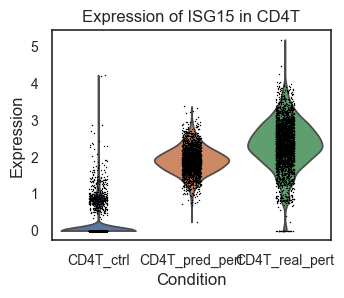

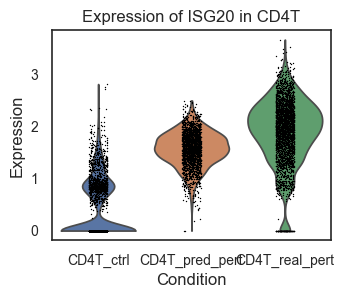

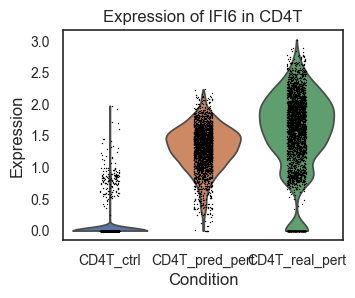

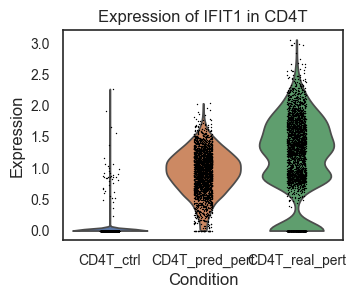

In [16]:
plot_violin_compare_pert(result,
                         genes=diff_genes_covid[:5],
                         ctrl_label='CD4T_ctrl',
                         real_label='CD4T_real_pert',
                         pred_label='CD4T_pred_pert',
                         cell_type='CD4T',
                        #  save_path='./violin_compare_DEGs.pdf',
                         show=True)


In [17]:
from scipy.stats import wasserstein_distance
import numpy as np
import pandas as pd

def compute_wasserstein(adata, gene, real_label, pred_label, condition_key='condition'):
    gene_idx = adata.var_names.get_loc(gene)

    real_expr = adata[adata.obs[condition_key] == real_label].X[:, gene_idx]
    pred_expr = adata[adata.obs[condition_key] == pred_label].X[:, gene_idx]

    if not isinstance(real_expr, np.ndarray):
        real_expr = real_expr.toarray().flatten()
    else:
        real_expr = real_expr.flatten()

    if not isinstance(pred_expr, np.ndarray):
        pred_expr = pred_expr.toarray().flatten()
    else:
        pred_expr = pred_expr.flatten()

    return wasserstein_distance(real_expr, pred_expr)

def compute_wasserstein_for_genes(adata, genes, real_label, pred_label, condition_key='condition'):
    results = []
    for gene in genes:
        try:
            wass = compute_wasserstein(adata, gene, real_label, pred_label, condition_key)
            results.append({
                'gene': gene,
                'wasserstein': wass
            })
        except Exception as e:
            print(f"⚠️ Gene {gene} failed: {e}")
    return pd.DataFrame(results)

# ✅ 获取所有基因名
all_genes = result.var_names.tolist()

# ✅ 计算全部基因的 Wasserstein 距离
df_wass = compute_wasserstein_for_genes(
    result,
    genes=all_genes,
    real_label='CD4T_real_pert',
    pred_label='CD4T_pred_pert',
    condition_key='condition'
)

# ✅ 查看前几行结果
# print(df_wass.head())
# 计算平均 Wasserstein 距离
mean_wass = df_wass['wasserstein'].mean()
print(f"平均 Wasserstein 距离：{mean_wass:.4f}")

# 计算中位数 Wasserstein 距离
median_wass = df_wass['wasserstein'].median()
print(f"中位数 Wasserstein 距离：{median_wass:.4f}")


平均 Wasserstein 距离：0.0317
中位数 Wasserstein 距离：0.0113


In [ ]:
from scipy.stats import wasserstein_distance
from scipy.stats import wasserstein_distance
import numpy as np

def compute_wasserstein(adata, gene, real_label, pred_label, condition_key='condition'):
    gene_idx = adata.var_names.get_loc(gene)

    real_expr = adata[adata.obs[condition_key] == real_label].X[:, gene_idx]
    pred_expr = adata[adata.obs[condition_key] == pred_label].X[:, gene_idx]

    if not isinstance(real_expr, np.ndarray):
        real_expr = real_expr.toarray().flatten()
    else:
        real_expr = real_expr.flatten()

    if not isinstance(pred_expr, np.ndarray):
        pred_expr = pred_expr.toarray().flatten()
    else:
        pred_expr = pred_expr.flatten()

    return wasserstein_distance(real_expr, pred_expr)

def compute_wasserstein_for_genes(adata, genes, real_label, pred_label, condition_key='condition'):
    results = []
    for gene in genes:
        wass = compute_wasserstein(adata, gene, real_label, pred_label, condition_key)
        results.append({
            'gene': gene,
            'wasserstein': wass
        })
    return pd.DataFrame(results)
df_wass = compute_wasserstein_for_genes(
    result,
    genes=diff_genes_covid[:5],
    real_label='CD4T_real_pert',
    pred_label='CD4T_pred_pert',
    condition_key='condition'
)

print(df_wass.sort_values(by='wasserstein'))


    gene  wasserstein
3   IFI6     0.238538
4  IFIT3     0.250399
2  ISG20     0.271282
1  ISG15     0.277990
0    B2M     0.392966


C:\Users\jerry-ai\AppData\Local\Temp\ipykernel_66824\4095401955.py:24: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(real_expr, label='Real', shade=True)
C:\Users\jerry-ai\AppData\Local\Temp\ipykernel_66824\4095401955.py:25: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(pred_expr, label='Pred', shade=True)


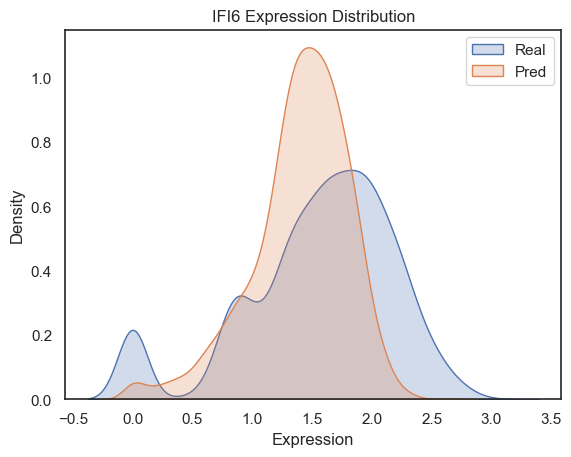

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_gene_distribution(adata, gene, real_label, pred_label, condition_key='condition'):
    gene_idx = adata.var_names.get_loc(gene)

    real_expr = adata[adata.obs[condition_key] == real_label].X[:, gene_idx]
    pred_expr = adata[adata.obs[condition_key] == pred_label].X[:, gene_idx]

    if not isinstance(real_expr, np.ndarray):
        real_expr = real_expr.toarray().flatten()
    else:
        real_expr = real_expr.flatten()

    if not isinstance(pred_expr, np.ndarray):
        pred_expr = pred_expr.toarray().flatten()
    else:
        pred_expr = pred_expr.flatten()

    sns.kdeplot(real_expr, label='Real', shade=True)
    sns.kdeplot(pred_expr, label='Pred', shade=True)
    plt.title(f'{gene} Expression Distribution')
    plt.xlabel('Expression')
    plt.ylabel('Density')
    plt.legend()
    plt.show()


# 示例画 B2M 的表达分布对比
plot_gene_distribution(result, 'IFI6', 'CD4T_real_pert', 'CD4T_pred_pert')


In [ ]:
result.obs['condition']

0-0            CD4T_ctrl
1-0            CD4T_ctrl
2-0            CD4T_ctrl
3-0            CD4T_ctrl
4-0            CD4T_ctrl
               ...      
3122-2    CD4T_real_pert
3123-2    CD4T_real_pert
3124-2    CD4T_real_pert
3125-2    CD4T_real_pert
3126-2    CD4T_real_pert
Name: condition, Length: 8001, dtype: category
Categories (3, object): ['CD4T_ctrl', 'CD4T_pred_pert', 'CD4T_real_pert']

In [ ]:
import scanpy as sc

# 选择分析目标：真实扰动 vs 控制组
adata = result
adata_real = adata[adata.obs['condition'].isin(['CD4T_ctrl', 'CD4T_real_pert'])].copy()

# 标准差异表达分析（使用 Wilcoxon）
sc.tl.rank_genes_groups(adata_real, groupby='condition', reference='CD4T_ctrl',
                        groups=['CD4T_real_pert'], method='wilcoxon')

# 保存结果为数据框
real_deg = sc.get.rank_genes_groups_df(adata_real, group='CD4T_real_pert')


In [ ]:
adata_pred = adata[adata.obs['condition'].isin(['CD4T_ctrl', 'CD4T_pred_pert'])].copy()

sc.tl.rank_genes_groups(adata_pred, groupby='condition', reference='CD4T_ctrl',
                        groups=['CD4T_pred_pert'], method='wilcoxon')

pred_deg = sc.get.rank_genes_groups_df(adata_pred, group='CD4T_pred_pert')

In [ ]:
# 设置筛选阈值（如 log2FC > 1 且 p < 0.05）
real_sig = real_deg[(real_deg['logfoldchanges'].abs() > 1) & (real_deg['pvals_adj'] < 0.05)]
pred_sig = pred_deg[(pred_deg['logfoldchanges'].abs() > 1) & (pred_deg['pvals_adj'] < 0.05)]
real_sig,pred_sig

(       names     scores  logfoldchanges          pvals      pvals_adj
 0      ISG15  62.229359        5.326104   0.000000e+00   0.000000e+00
 1       IFI6  58.841118        5.983657   0.000000e+00   0.000000e+00
 2      ISG20  56.727085        3.220724   0.000000e+00   0.000000e+00
 3      IFIT3  55.299271        7.303085   0.000000e+00   0.000000e+00
 4      IFIT1  53.544773        7.140417   0.000000e+00   0.000000e+00
 ...      ...        ...             ...            ...            ...
 6976  NSMCE1  -8.707665       -1.080872   3.101985e-18   2.615384e-16
 6978  AMICA1  -8.874249       -2.034656   7.040692e-19   6.158845e-17
 6981   HMGB2  -9.422421       -1.068630   4.408023e-21   4.168560e-19
 6996    RGCC -22.581551       -1.421657  6.579811e-113  2.001979e-110
 6997    FTH1 -23.932802       -1.136608  1.395744e-126  4.883710e-124
 
 [124 rows x 5 columns],
        names     scores  logfoldchanges          pvals      pvals_adj
 0      ISG15  59.378498        4.959336   0.00000

In [ ]:
# 以 log2FC 作为排序依据，构建 GSEA 输入
# 你需要一个 pandas.Series，index 是基因名，value 是 log2FC
ranked_real = real_deg.set_index('names')['logfoldchanges'].sort_values(ascending=False)
ranked_pred = pred_deg.set_index('names')['logfoldchanges'].sort_values(ascending=False)

In [ ]:
import gseapy as gp
# GSEA for real
real_gsea = gp.prerank(
    rnk=ranked_real,
    gene_sets='KEGG_2021_Human',
    processes=4,
    permutation_num=100,
    outdir=None,
    seed=42
)

# GSEA for predicted
pred_gsea = gp.prerank(
    rnk=ranked_pred,
    gene_sets='KEGG_2021_Human',
    processes=4,
    permutation_num=100,
    outdir=None,
    seed=42
)


C:\Users\jerry-ai\AppData\Local\Temp\ipykernel_14420\3433109990.py:3: DeprecationWarning: processes is deprecated; use threads
  real_gsea = gp.prerank(
2025-07-06 15:27:11,224 [WARNING] Duplicated values found in preranked stats: 3.36% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
C:\Users\jerry-ai\AppData\Local\Temp\ipykernel_14420\3433109990.py:13: DeprecationWarning: processes is deprecated; use threads
  pred_gsea = gp.prerank(
2025-07-06 15:27:11,422 [WARNING] Duplicated values found in preranked stats: 7.30% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


In [ ]:
df_real = real_gsea.res2d.copy()
df_pred = pred_gsea.res2d.copy()

# 找出共同通路
common_terms = set(df_real.index) & set(df_pred.index)
print(f"共同富集通路数: {len(common_terms)}")

共同富集通路数: 232


In [ ]:
# NES 数据存储在 .res2d 中
df_real = real_gsea.res2d.reset_index().rename(columns={"Term": "Pathway", "NES": "NES_real"})
df_pred = pred_gsea.res2d.reset_index().rename(columns={"Term": "Pathway", "NES": "NES_pred"})

In [ ]:
print(df_pred)

     index     Name                                      Pathway        ES  \
0        0  prerank                                     Ribosome -0.606715   
1        1  prerank                                  Spliceosome -0.597325   
2        2  prerank                                RNA transport -0.593855   
3        3  prerank                       VEGF signaling pathway -0.650387   
4        4  prerank                         Basal cell carcinoma -0.633116   
..     ...      ...                                          ...       ...   
227    227  prerank                            GABAergic synapse -0.355341   
228    228  prerank                            Adherens junction -0.338893   
229    229  prerank  Protein processing in endoplasmic reticulum -0.311438   
230    230  prerank                        Tryptophan metabolism -0.337053   
231    231  prerank                       Glutathione metabolism -0.291883   

     NES_pred NOM p-val FDR q-val FWER p-val  Tag %  Gene %  \


In [ ]:
def plot_top_common_pathways_from_df(
        df_real, df_pred,
        score_col_real='NES_real',
        score_col_pred='NES_pred',
        term_col='Pathway',
        top_n=20,
        title="Top Pathway NES Comparison",
        same_direction=True,          # 新增：是否要求 NES 同号
        wrap_width=40                 # 可调：通路名换行宽度
    ):
    """
    对比真实组和预测组 GSEA 结果中 NES 同向的重叠通路
    ...

    same_direction : bool
        True  → 仅保留 NES_real 和 NES_pred 同号（同向富集）通路  
        False → 只取两表交集，不管 NES 方向
    """
    import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, textwrap

    # 1) 合并两张表
    df_merged = pd.merge(
        df_real[[term_col, score_col_real]],
        df_pred[[term_col, score_col_pred]],
        on=term_col,
        how='inner'
    )

    # 2) 方向一致过滤（可选）
    if same_direction:
        df_merged = df_merged[
            (df_merged[score_col_real] * df_merged[score_col_pred]) > 0
        ]

    print(f"方向一致的重叠通路数: {len(df_merged)}")

    # 3) 长表 & 其余绘图逻辑保持不变
    df_long = pd.melt(df_merged,
                      id_vars=[term_col],
                      value_vars=[score_col_real, score_col_pred],
                      var_name='Condition',
                      value_name='Score')

    df_long['Condition'] = df_long['Condition'].map({
        score_col_real: 'Stimulus',
        score_col_pred: 'Predict'
    })

    wrap = lambda t: '\n'.join(textwrap.wrap(str(t), width=wrap_width))
    df_long['Term_wrapped'] = df_long[term_col].apply(wrap)

    top_terms = (df_long.groupby(term_col)['Score']
                 .mean().abs().sort_values(ascending=False)
                 .head(top_n).index)
    df_long = df_long[df_long[term_col].isin(top_terms)]

    order = df_long.groupby(term_col)['Score'].mean().loc[top_terms[::-1]]
    df_long['Term_wrapped'] = pd.Categorical(
        df_long['Term_wrapped'],
        categories=[wrap(t) for t in order.index],
        ordered=True)

    plt.figure(figsize=(12, max(6, 0.4 * top_n)))
    ax = sns.barplot(data=df_long, x='Score', y='Term_wrapped',
                     hue='Condition',
                     palette={'Predict': 'skyblue', 'Stimulus': 'hotpink'})

    for c in ax.containers:
        ax.bar_label(c, fmt="%.2f", label_type="edge", padding=3)

    plt.axvline(0, color='black', linestyle='--')
    plt.title(title)
    plt.xlabel("Normalized Enrichment Score (NES)")
    plt.ylabel("Pathway")
    plt.legend(title='Condition', loc='lower right')
    plt.tight_layout()
    plt.show()


In [ ]:
def plot_top_common_pathways_bubble(
        df_real, df_pred,
        score_col_real='NES_real',
        score_col_pred='NES_pred',
        term_col='Pathway',
        top_n=20,
        title="Stimulus vs. Predict NES (Bubble)",
        same_direction=False,          # True→只保留同向；False→同时看匹配与失配
        size_scale=200,                # 气泡放大因子
        annotate=True,                 # 是否在点旁标注通路名
        wrap_width=35                  # 通路名自动换行宽度
    ):
    """
    以气泡图比较 Stimulus 与 Predict 的 NES：
    x 轴 = Stimulus NES，y 轴 = Predict NES，气泡大小 = |NES| 平均。
    """
    import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, textwrap

    # 1) 合并两张表
    df_merge = pd.merge(
        df_real[[term_col, score_col_real]],
        df_pred[[term_col, score_col_pred]],
        on=term_col, how='inner'
    )

    # 2) 过滤同向（可选）
    if same_direction:
        df_merge = df_merge[(df_merge[score_col_real] * df_merge[score_col_pred]) > 0]

    # 3) 只取 top_n（按两列绝对 NES 均值排序）
    df_merge['abs_mean'] = (df_merge[score_col_real].abs() + df_merge[score_col_pred].abs()) / 2
    df_top = (df_merge.sort_values('abs_mean', ascending=False)
                        .head(top_n)
                        .copy())

    # 4) 计算绘图数据
    df_top['BubbleSize'] = df_top['abs_mean'] * size_scale
    df_top['SameDir'] = np.sign(df_top[score_col_real]) == np.sign(df_top[score_col_pred])

    # 5) 绘图
    plt.figure(figsize=(8, 8))
    palette = {True: "steelblue", False: "salmon"}  # 可自定义
    sns.scatterplot(
        data=df_top,
        x=score_col_real, y=score_col_pred,
        size='BubbleSize', sizes=(40, df_top['BubbleSize'].max()),
        hue='SameDir', palette=palette, alpha=0.7, edgecolor='k', linewidth=0.5
    )

    # 参考对角线
    plt.axline((0, 0), slope=1, linestyle='--', color='gray')
    plt.xlabel("Stimulus NES")
    plt.ylabel("Predict NES")
    plt.title(title)

    # 6) 气泡标注
    if annotate:
        wrap = lambda s: "\n".join(textwrap.wrap(str(s), width=wrap_width))
        for _, row in df_top.iterrows():
            plt.text(row[score_col_real], row[score_col_pred],
                     wrap(row[term_col]), fontsize=8,
                     ha='center', va='center')

    plt.tight_layout()
    plt.show()


方向一致的重叠通路数: 110


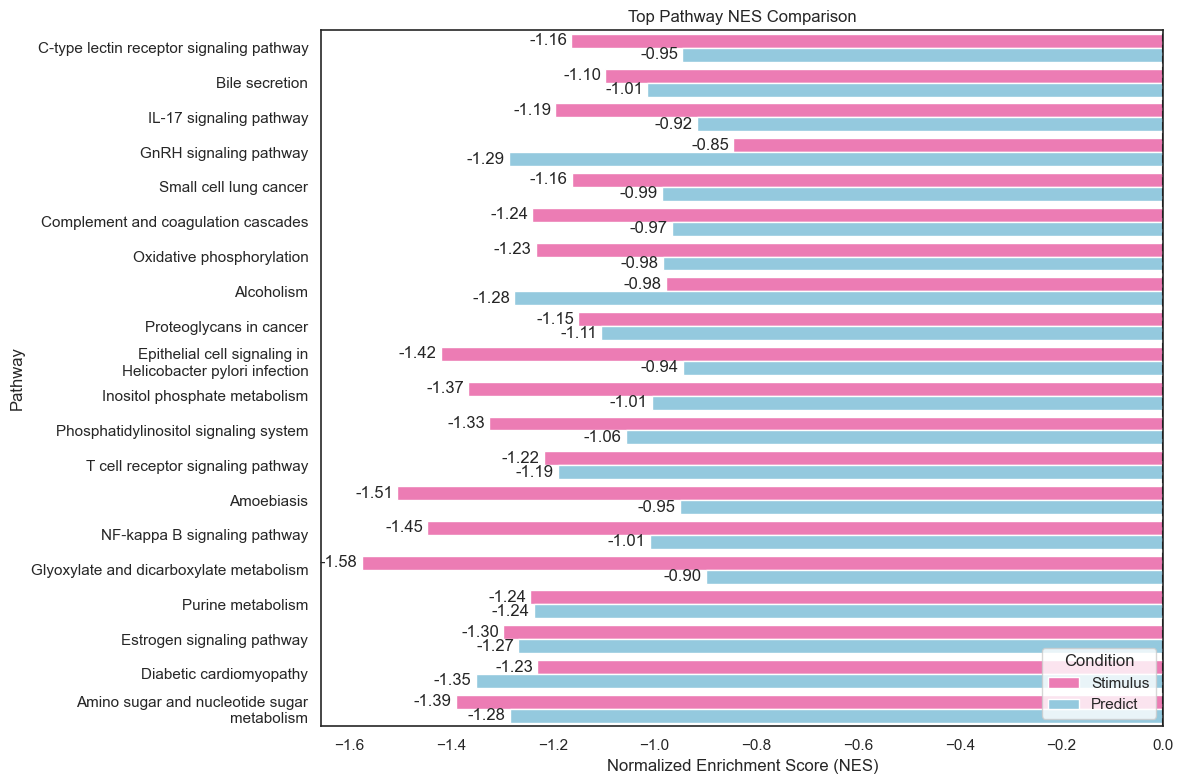

In [ ]:
# 已有的 df_real / df_pred
# df_real = real_gsea.res2d.reset_index().rename(columns={"Term": "Term", "NES": "NES_real"})
# df_pred = pred_gsea.res2d.reset_index().rename(columns={"Term": "Term", "NES": "NES_pred"})

plot_top_common_pathways_from_df(df_real, df_pred, top_n=20)


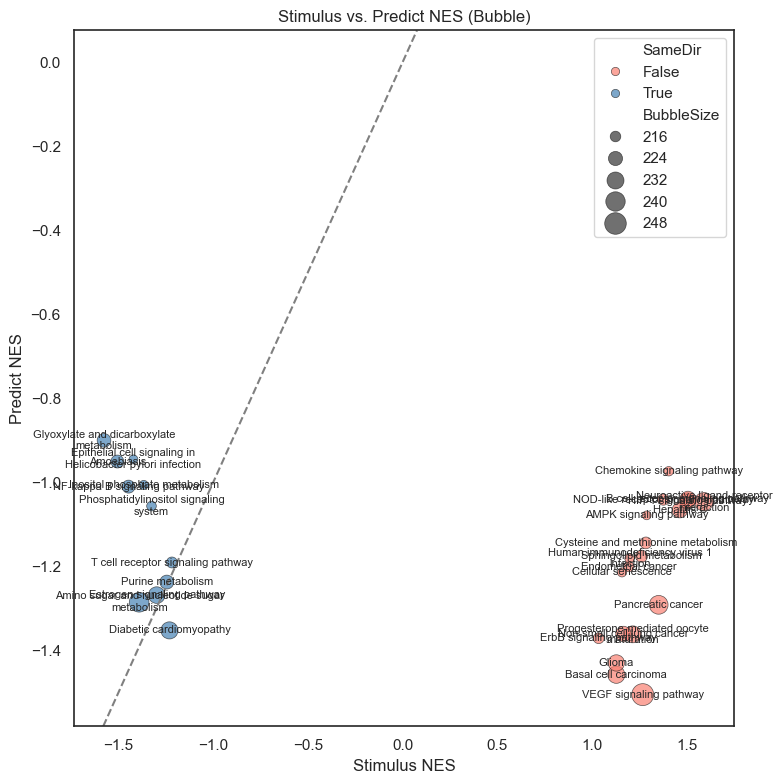

In [ ]:
plot_top_common_pathways_bubble(
    df_real, df_pred,
    score_col_real='NES_real',
    score_col_pred='NES_pred',
    term_col='Pathway',
    top_n=30,              # 看 30 条
    same_direction=False,  # 同时想观察同向与反向
    size_scale=180         # 调整气泡大小
)


In [ ]:
df_pred.to_csv("enrichr_pbmc_CD4T_prd.csv",index=False)

In [ ]:
! pip install matplotlib_venn

Looking in indexes: https://pypi.mirrors.ustc.edu.cn/simple/
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for matplotlib_venn: filename=matplotlib_venn-1.1.2-py3-none-any.whl size=45437 sha256=01faf3ff8b391731b7f65b7172fe0af366abc55ea2e73482f2b73ec33b48cb7b
  Stored in directory: c:\users\jerry-ai\appdata\local\pip\cache\wheels\28\46\35\1a454ab580b0621f5d67a5a87049c8829b8a017d8c0251bb27
Successfully built matplotlib_venn


In [ ]:
df_real

,index,Name,Pathway,ES,NES_real,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,0,prerank,Neuroactive ligand-receptor interaction,0.767136,1.589027,0.0,0.199891,0.16,12/53,7.65%,EDN1;INSL3;NPW;PARD3;GIPR;PMCH;SSTR3;CHRNA6;AD...
1,1,prerank,Glyoxylate and dicarboxylate metabolism,-0.791764,-1.575713,0.036364,0.990666,0.53,2/15,3.66%,AMT;AFMID
2,2,prerank,B cell receptor signaling pathway,0.799905,1.505261,0.044444,0.632987,0.54,5/30,4.60%,RAC3;CD19;CD22;DAPP1;IFITM1
3,3,prerank,Amoebiasis,-0.820964,-1.505125,0.0,1.0,0.91,11/26,9.95%,LAMA2;CD1D;CSF2;IL1B;CD14;CXCL1;CXCL2;ITGB2;VC...
4,4,prerank,HIF-1 signaling pathway,0.778212,1.501883,0.042553,0.451605,0.6,3/37,3.33%,EDN1;ERBB2;ANGPT1
...,...,...,...,...,...,...,...,...,...,...,...
227,227,prerank,Parkinson disease,-0.151032,-0.319195,1.0,1.0,1.0,16/76,30.04%,TUBA4A;CAMK2G;PINK1;CASP9;KLC2;ITPR2;TUBA1C;PR...
228,228,prerank,Peroxisome,-0.165852,-0.319103,1.0,1.0,1.0,13/36,34.97%,CRAT;PEX1;PEX3;CAT;PECR;ECH1;PEX11B;PEX6;ECI2;...
229,229,prerank,RNA degradation,0.140205,0.270768,1.0,1.0,1.0,1/40,4.37%,PNPT1
230,230,prerank,Mismatch repair,-0.150879,-0.258499,1.0,0.999918,1.0,6/19,38.48%,RPA4;MSH6;MSH3;MSH2;MLH3;POLD3


In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# === 加载你的数据 ===
# 请将文件名替换为实际CSV路径
df = df_pred

# === 数据预处理 ===
# 清理百分比格式
# df['Tag %'] = df['Tag %'].astype(str).str.rstrip('%').astype(float)
df['Gene %'] = df['Gene %'].astype(str).str.rstrip('%').astype(float)

# 清洗 FDR q-val 并转为 float
df['FDR q-val'] = df['FDR q-val'].astype(str).str.replace('%', '').str.strip()
df['FDR q-val'] = df['FDR q-val'].replace(['nan', 'NaN', ''], np.nan).astype(float)

# 去除无效数据
df = df.dropna(subset=['Name', 'Pathway', 'FDR q-val'])

# === 构建节点和链接 ===
labels = pd.unique(df[['Name', 'Pathway']].values.ravel())
label_dict = {label: i for i, label in enumerate(labels)}

sources = df['Name'].map(label_dict)
targets = df['Pathway'].map(label_dict)
values = df['Tag %']
bubble_size = df['Gene %']

# === 映射颜色（-log10(FDR q-val) → rgba） ===
fdr_scores = -np.log10(df['FDR q-val'].replace(0, 1e-5).fillna(1e-5))
norm = mcolors.Normalize(vmin=fdr_scores.min(), vmax=fdr_scores.max())
cmap = cm.get_cmap('RdBu_r')

color_vals = ['rgba({},{},{},{})'.format(int(r*255), int(g*255), int(b*255), a)
              for r, g, b, a in cmap(norm(fdr_scores))]

# === 绘制 Sankey 图 ===
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=15,
        line=dict(color="black", width=0.5),
        label=labels.tolist(),
        color="gray"
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        color=color_vals,
        customdata=bubble_size,
        hovertemplate='Tag %%: %{value}<br>Gene %%: %{customdata}<extra></extra>',
    )
)])

fig.update_layout(title_text="Sankey Bubble Chart (Pathway Enrichment)", font_size=12)
fig.show()


C:\Users\jerry-ai\AppData\Local\Temp\ipykernel_14420\3532374308.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('RdBu_r')
